In [1]:
import pandas as pd
from pathlib import Path
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import PIL

In [2]:
sys.path.append('../..')
import src.utils as utils


In [3]:
root = Path('/hpc/group/kamaleswaranlab/EmoryDataset/Images/chest_xrays')

YEARS = [2015, 2016, 2017, 2018, 2019, 2020, 2021]
image_dir = "extracted-images"
metadata = "metadata_with_supertables_filtered_notes_filtered_matching_times_min_series_img_paths_datetime_hashed.csv"
notes = "all_notes.csv"

In [4]:
metadatadf = pd.read_csv(root / metadata)
notesdf = pd.read_csv(root / notes)

/tmp/ipykernel_1877636/3683124971.py:1: DtypeWarning: Columns (22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  metadatadf = pd.read_csv(root / metadata)
/tmp/ipykernel_1877636/3683124971.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  notesdf = pd.read_csv(root / notes)


In [67]:
mask = notesdf['DOC_TEXT'].str.contains('Improved aeration', case=False, na=False)
matching_rows = notesdf[mask]
len(matching_rows)

2626

In [68]:
print(matching_rows['DOC_TEXT'].iloc[470])

EXAM: XR Chest 1 View Portable

ESRC.4.6.1

CLINICAL INDICATION: Respiratory failure

COMPARISON: Earlier Today  

FINDINGS: 
Support Devices: Support lines and tubes are adequately positioned. 

Lungs/pleura: No pneumothorax. Improved aeration of the left lung. 

Heart/mediastinum: Unchanged.

Other: None

IMPRESSION: 
Improved aeration of the left lung.





In [201]:
templates = [
    'Left lung clear, opacities in the right lung.',
    'Right lung clear, opacities in the left lung',
    #'Persistent bilateral opacities',
    'Persistent bilateral opacities, consistent with pulmonary edema',
    'Persistent bilateral opacities, consistent with atelectasis',
    'Persistent bilateral opacities, consistent with pleural effusions',
    #'Heart is enlarged',
    #'Stable cardiac and mediastinal contours',
    'Lungs are clear, persistent cardiomegaly',
    #'Lungs are clear, stable cardiac and mediastinal contours',
    #'Interstitial opacities, likely represent pulmonary edema.',
    'Persistent focal consolidation.',
    'Persistent bilateral opacities, likely represent atelectasis',
    #'Concern for aispace disease, or interstitial abnormality',
    'lung opacities indicative of pneumonia',
    'No acute cardiopulmonary abnormality.',
    #'Low lung volumes',
    #'Improved aeration of both lungs',
    #'Improved aeration in the right lung.',
    #'Improved aeration in the left lung'
]

In [202]:
label_names = dict(zip(range(len(templates)), templates))

In [70]:
from urllib.request import urlopen
from PIL import Image
from open_clip import create_model_from_pretrained, get_tokenizer


os.environ["PYTORCH_CUDA_ALLOC_CONF"]="expandable_segments:True"
os.environ["HF_HOME"] = "/hpc/dctrl/ma618"

# Load the model and config files from the Hugging Face Hub
model, preprocess = create_model_from_pretrained('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
tokenizer = get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
model.cuda()

/hpc/dctrl/ma618/torch/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CustomTextCLIP(
  (visual): TimmModel(
    (trunk): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768

In [80]:
import torch

In [203]:
prompts = templates
context_length = 256
texts = tokenizer(prompts, context_length=context_length).cuda()
print(texts.shape)

torch.Size([10, 256])


In [204]:
text_features = model.encode_text(texts, normalize = True)

In [205]:
model.logit_scale.exp()

tensor(85.2323, device='cuda:0', grad_fn=<ExpBackward0>)

In [206]:
root = Path('/hpc/group/kamaleswaranlab/EmoryDataset/Images/chest_xrays')
embedding_path = root / 'BioMedCLIP_embeddings'
dimreduce = root / 'dimReduce'
embedding_matrix = np.load(embedding_path / 'embedding_matrix.npy')

In [207]:
embedding_matrix.shape, text_features.shape

((255834, 512), torch.Size([10, 512]))

In [208]:
embedding_matrix = torch.tensor(embedding_matrix).cuda()

In [209]:
logits = (model.logit_scale.exp() * embedding_matrix @ text_features.t()).detach().softmax(dim=-1)
    #sorted_indices = torch.argsort(logits, dim=-1, descending=True)

    #logits = logits.cpu().numpy()
    #sorted_indices = sorted_indices.cpu().numpy()

In [210]:
labels_clip = logits.argmax(dim = -1).detach().cpu().numpy()

IndexError: index 255131 is out of bounds for axis 0 with size 254432

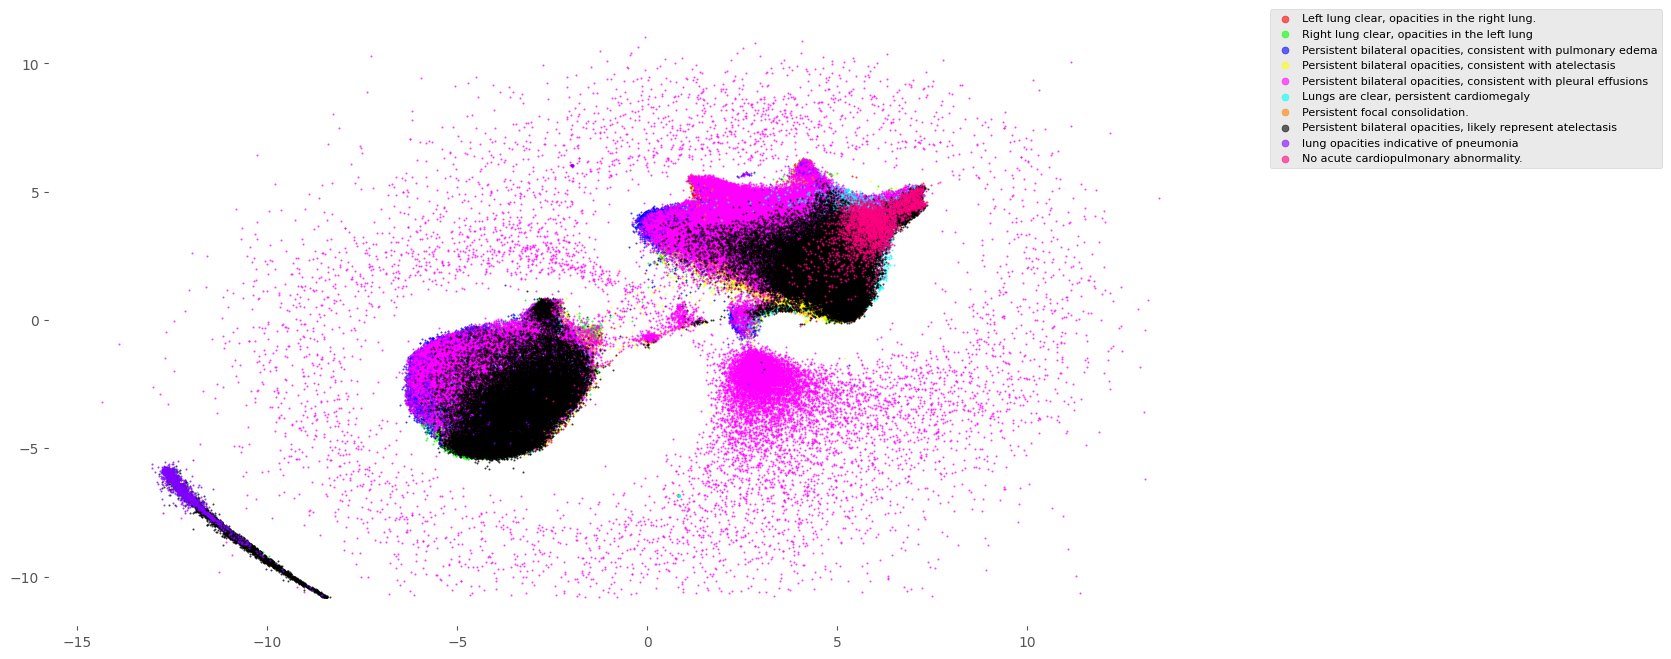

In [320]:
nn = 45
min_dist = 0.1
metric = 'euclidean'
umap_embeddings = pd.read_csv(dimreduce / f'umap_{nn}_{min_dist}_{metric}.csv')
clean_embeddings, mask = remove_umap_outliers(umap_embeddings.values, method='iqr', threshold=1.5)
fig, ax = plot_umap_names(clean_embeddings, labels = labels_clip[mask], label_names = label_names, point_size = 1, trajectory_indices = indices,
                          colors = distinct_colors, title=f'umap_{nn}_{min_dist}_{metric}', figsize = (15,8))

## ARDS

In [251]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize

In [330]:
csn = '53271877110'#'4048447111'
hashed = utils.hash_value(csn)
hashed

'be88ec7a2d2c8576b12d6ead27c37ac543e4204fa819702a494e29494589858a'

In [331]:
supertable_path = root / 'matched_supertables_with_images'
embedding_path = root / 'BioMedCLIP_embeddings'

In [332]:
df = metadatadf.loc[metadatadf.supertable_path_hashed == str(supertable_path / (hashed + '.pickle'))]

In [341]:
metadatadf.iloc[0]

EMPI_NBR                  da75ddb523faf9957500fdcd357ea98332caf28a431593...
ENCOUNTER_NBR             724e5550696600a69535351ed3f1db001ed4df3440fcf3...
BED_LOCATION_START                                      2015-01-09 12:41:57
BED_LOCATION_END                                        2015-01-12 20:53:23
StudyDate                                                        2015-01-10
PatientID                 da75ddb523faf9957500fdcd357ea98332caf28a431593...
StudyDescription                                   XR CHEST 1 VIEW PORTABLE
SeriesNumber                                                              1
SeriesDescription                                                        AP
file                      /labs/kamaleswaranlab/niffler-data/chest_xrays...
PatientSex                                                                M
PatientAge                                                             061Y
PAT_ID                    4638bdabac895e42cf5e556ad317fb1cbe239804df3e2e...
ENCOUNTER_ID

In [333]:
supertable = pd.read_pickle(supertable_path / (hashed + '_image_interpolated.pickle'))
interp_embedding = np.load(embedding_path / (hashed + '_interpolated_embeddings.npy'))

In [334]:
cxrs = supertable.loc[supertable.cxr_timing.notna(), 'cxr_timing']
len(cxrs)

1

2017-05-18 07:57:00


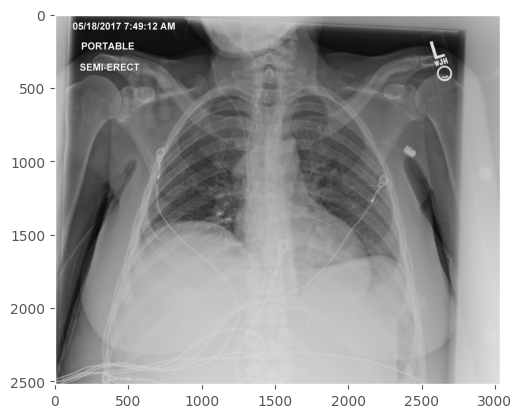

In [335]:
images = cxrs.values
input_imgs = []
for i in range(len(images)):
    print(cxrs.index[i])
    img_path = root/ str(cxrs.index[i].year) / image_dir / (cxrs.values[i] + '.png')
    img = PIL.Image.open(img_path)
    input_imgs.append(img)
    plt.grid(False)
    plt.imshow(img, cmap = 'grey')
    plt.show()
    

In [336]:
inputimg = torch.stack([preprocess(img) for img in input_imgs]).cuda()
print(inputimg.shape)
with torch.no_grad():
    image_features = model.encode_image(inputimg)
    
#image_features = image_features.norm(dim=-1, keepdim=True)

torch.Size([1, 3, 224, 224])


In [337]:

image_features = image_features.cpu().numpy()
image_features = normalize(image_features, norm='l2', axis=1)

In [339]:
indices = (image_features @ embedding_matrix.cpu().numpy().T).argmax(axis =  -1)

In [340]:
indices

array([255131])

In [281]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

distinct_colors = [
    '#FF0000',   # Pure Red
    '#00FF00',   # Pure Green
    '#0000FF',   # Pure Blue
    '#FFFF00',   # Yellow
    '#FF00FF',   # Magenta
    '#00FFFF',   # Cyan
    '#FF8000',   # Orange
    '#000000',   # Black
    '#8000FF',   # Purple
    '#FF0080'    # Pink
]
def remove_umap_outliers(embeddings, method='zscore', threshold=3):
    """
    Remove outliers from UMAP embeddings using various methods.
    
    Parameters:
    -----------
    embeddings : np.ndarray
        2D array of shape (n_samples, 2) containing UMAP embeddings
    method : str, default='zscore'
        Method to use for outlier detection:
        - 'zscore': Remove points beyond z standard deviations
        - 'iqr': Remove points beyond IQR * threshold
        - 'isolation_forest': Use Isolation Forest algorithm
    threshold : float, default=3
        Threshold for outlier detection
        
    Returns:
    --------
    clean_embeddings : np.ndarray
        Embeddings with outliers removed
    mask : np.ndarray
        Boolean mask indicating which points were kept
    """
    
    if method == 'zscore':
        # Calculate z-scores for each dimension
        z_scores = np.abs(stats.zscore(embeddings))
        mask = np.all(z_scores < threshold, axis=1)
        
    elif method == 'iqr':
        # Calculate IQR for each dimension
        Q1 = np.percentile(embeddings, 25, axis=0)
        Q3 = np.percentile(embeddings, 75, axis=0)
        IQR = Q3 - Q1
        
        # Create bounds
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Create mask for points within bounds
        mask = np.all((embeddings >= lower_bound) & (embeddings <= upper_bound), axis=1)
        
    elif method == 'isolation_forest':
        from sklearn.ensemble import IsolationForest
        iso_forest = IsolationForest(contamination=0.1, random_state=42)
        mask = iso_forest.fit_predict(embeddings) == 1
        
    else:
        raise ValueError(f"Unknown method: {method}")
    
    clean_embeddings = embeddings[mask]
    
    return clean_embeddings, mask

def plot_umap_names(embeddings, 
              labels=None, 
              label_names=None,  # Added parameter
              colors=None,
              figsize=(12, 8),
              point_size=5,
              alpha=0.6,
              title="UMAP Visualization",
              trajectory_indices=None,  # Added parameter
              trajectory_color='green',  # Added parameter
              trajectory_width=2,      # Added parameter
              save_path=None,
              random_state=42):
    """
    Create a beautiful UMAP scatter plot.
    
    Parameters:
    -----------
    embeddings : np.ndarray
        2D array of shape (n_samples, 2) containing UMAP embeddings
    labels : array-like, optional
        Labels for coloring the points. If None, all points will be same color
    label_names : dict, optional
        Dictionary mapping label values to display names. If None, uses original labels
    colors : list or str, optional
        Colors to use for different labels. If None, uses default color palette
    figsize : tuple, default=(12, 8)
        Size of the figure (width, height)
    point_size : int, default=5
        Size of the scatter points
    alpha : float, default=0.6
        Transparency of points (0 to 1)
    title : str, default="UMAP Visualization"
        Title of the plot
    save_path : str, optional
        If provided, saves the plot to this path
    random_state : int, default=42
        Random state for reproducibility
    """
    
    # Set style
    plt.style.use('ggplot')
    np.random.seed(random_state)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set background color
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Plot points
    if labels is not None:
        # If colors not provided, use a nice color palette
        if colors is None:
            colors = sns.color_palette("husl", n_colors=len(np.unique(labels)))
        
        # Create scatter plot for each label
        for idx, label in enumerate(np.unique(labels)):
            mask = labels == label
            # Get display name from label_names dict if provided, otherwise use original label
            display_name = label_names.get(label, str(label)) if label_names else str(label)
            ax.scatter(embeddings[mask, 0], 
                      embeddings[mask, 1],
                      c=[colors[idx]],
                      s=point_size,
                      alpha=alpha,
                      label=display_name)
        
        # Add legend with smaller font
        ax.legend(bbox_to_anchor=(1.05, 1), 
                 loc='upper left', 
                 borderaxespad=0,
                 frameon=True,
                 fontsize=8,  # Reduced font size
                 markerscale=5,  # Slightly smaller markers in legend
                 handletextpad=0.5)  # Reduced spacing between marker and text
    else:
        # Single color plot if no labels
        ax.scatter(embeddings[:, 0],
                  embeddings[:, 1],
                  c='steelblue',
                  s=point_size,
                  alpha=alpha)
        
    # Plot trajectory if indices provided
    if trajectory_indices is not None:
        trajectory_points = embeddings[trajectory_indices]
        
        # Plot the trajectory line
        ax.plot(trajectory_points[:, 0], 
                trajectory_points[:, 1], 
                color=trajectory_color, 
                linewidth=trajectory_width,
                zorder=3)  # Ensure line appears above scatter points
        
        # Plot start point (cross)
        ax.plot(trajectory_points[0, 0], trajectory_points[0, 1], 
                'x', 
                color=trajectory_color, 
                markersize=10, 
                markeredgewidth=2,
                zorder=4)
        
        # Plot end point (cross with circle)
        ax.plot(trajectory_points[-1, 0], trajectory_points[-1, 1], 
                'x', 
                color=trajectory_color, 
                markersize=10, 
                markeredgewidth=2,
                zorder=4)
        ax.plot(trajectory_points[-1, 0], trajectory_points[-1, 1], 
                'o', 
                color='none',
                markeredgecolor=trajectory_color,
                markersize=15, 
                markeredgewidth=2,
                zorder=4)
    
    
    # Customize plot
    ax.set_title(title, pad=20, size=14, fontweight='bold')
    ax.set_xlabel('UMAP 1', size=12)
    ax.set_ylabel('UMAP 2', size=12)
    
    # Remove ticks but keep grid
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add subtle spines
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('#CCCCCC')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
    return fig, ax

def plot_umap(embeddings, 
              labels=None, 
              colors=None,
              figsize=(12, 8),
              point_size=5,
              alpha=0.6,
              title="UMAP Visualization",
              save_path=None,
              random_state=42):
    """
    Create a beautiful UMAP scatter plot.
    
    Parameters:
    -----------
    embeddings : np.ndarray
        2D array of shape (n_samples, 2) containing UMAP embeddings
    labels : array-like, optional
        Labels for coloring the points. If None, all points will be same color
    colors : list or str, optional
        Colors to use for different labels. If None, uses default color palette
    figsize : tuple, default=(12, 8)
        Size of the figure (width, height)
    point_size : int, default=5
        Size of the scatter points
    alpha : float, default=0.6
        Transparency of points (0 to 1)
    title : str, default="UMAP Visualization"
        Title of the plot
    save_path : str, optional
        If provided, saves the plot to this path
    random_state : int, default=42
        Random state for reproducibility
    """
    
    # Set style
    plt.style.use('ggplot')
    np.random.seed(random_state)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set background color
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Plot points
    if labels is not None:
        # If colors not provided, use a nice color palette
        if colors is None:
            colors = sns.color_palette("husl", n_colors=len(np.unique(labels)))
        
        # Create scatter plot for each label
        for idx, label in enumerate(np.unique(labels)):
            mask = labels == label
            ax.scatter(embeddings[mask, 0], 
                      embeddings[mask, 1],
                      c=[colors[idx]],
                      s=point_size,
                      alpha=alpha,
                      label=str(label))
        
        # Add legend
        ax.legend(bbox_to_anchor=(1.05, 1), 
                 loc='upper left', 
                 borderaxespad=0,
                 frameon=True)
    else:
        # Single color plot if no labels
        ax.scatter(embeddings[:, 0],
                  embeddings[:, 1],
                  c='steelblue',
                  s=point_size,
                  alpha=alpha)
    
    # Customize plot
    ax.set_title(title, pad=20, size=14, fontweight='bold')
    ax.set_xlabel('UMAP 1', size=12)
    ax.set_ylabel('UMAP 2', size=12)
    
    # Remove ticks but keep grid
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add subtle spines
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('#CCCCCC')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
    return fig, ax